In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv,os,re
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
import gensim
import textblob
import sklearn
import numpy as np

C:\Users\Mudit\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:

df = pd.read_csv('lyrics.csv') #Initially has 362k rows. 

In [3]:
df.columns
#len(df['artist'].value_counts())
#len(df)

Index(['index', 'song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')

In [4]:
#Drop index column and all rows with Nan values and no lyrics
#Drop year column- has incorrect values (?)
df = df.drop(['index'],axis = 1)
df = df.drop(['year'],axis = 1)
df.dropna(axis = 0,inplace = True)
df = df[df['lyrics'].map(lambda x: len(x) > 30)] #Keeping a row only if the song's lyrics has at least 30 words

In [5]:
df['lyrics'] = df['lyrics'].map(lambda x: re.sub(r'\n','. ',x)) #Replace \n with full stops. 


In [6]:
len(df) #At this point, the dataset has about 260k songs

261780

In [7]:
#Remove non-English songs from the dataset
stop_words = set(stopwords.words('english'))
stop_words_subset = set([x for x in stop_words if 3 <= len(x) <= 5])
#sample_song_lyrics = df.iloc[53]['lyrics'].split(' ')
#print(sum(x in words.words() for x in sample_song_lyrics))
#print(f'Size of dataset before: {len(df)}')
df = df[df['lyrics'].map(lambda x: sum(y in x.split(' ') for y in stop_words_subset) > 0)]
#Taking too long to run


In [8]:
#TODO: Filter out non-English songs
#How to incorporate meta-data present in songs like Chorus Bridge etc?

#(df[df['artist'] == 'chick-corea-trio']) Artist only has 2 songs

#Remove all artists which have less than 10 songs

artist_count = df['artist'].value_counts().to_dict() #Dictionary of (artist,number_of_songs) key-value pairs
 
min_artist_set = [x[0] for x in artist_count.items() if x[1] >= 10] #Only keep those artists which have at least 10 songs



In [9]:
#old_songs = df[df['artist'] == 'beatles']
#len(min_artist_set)
#df.loc[df['artist'].isin(min_artist_set)]

df = df[df['artist'].map(lambda x: x in min_artist_set)] #Filtering the dataset to keep only those artists which have >= 10 songs

In [11]:

len(df) #Size of the dataset has come down to 210k songs

218856

In [12]:
meta_data = df[df['lyrics'].map(lambda x: any(t in x for t in ['Chorus','Bridge','Intro','Hook','Verse']))]
meta_data

,song,artist,genre,lyrics
2,honesty,beyonce-knowles,Pop,If you search. For tenderness. It isn't hard t...
3,you-are-my-rock,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I. [Verse 1:]. If I wrote..."
8,slow-love,beyonce-knowles,Pop,[Verse 1:]. I read all of the magazines. while...
16,poison,beyonce-knowles,Pop,You're bad for me I clearly get it. I don't se...
17,world-wide-women,beyonce-knowles,Pop,[Chorus:]. I'm a world wide woman WWW you can ...
21,bienvenue,beyonce-knowles,Pop,Beyonc - Intro:. Beyonce. IAM. Welcome. Welcom...
27,my-man,beyonce-knowles,Pop,you say that he's wrong. you say that he's no ...
28,what-s-it-gonna-be,beyonce-knowles,Pop,"1st verse:. hey you what's the deal, its poppi..."
30,a-girl-with-no-name,beyonce-knowles,Pop,You don't care about me at all. You treat me l...
34,i-can-t-take-no-more,beyonce-knowles,Pop,Verse 1:. It's really been weighing on me. Tel...


In [13]:
len(meta_data) #Only about 10% of the songs have this kind of meta-data. Not a viable feature to pick. 

22963

In [14]:
len(df)/len(df['artist'].value_counts())
#Average of 18 songs per artist - leaves artist wise lyrical analysis possible

#On removing artists with less than 10 songs, we get a ratio of 40+ i.e. the filtered dataset has on average, 40 or more songs per artist

44.284904896802914

In [15]:
#Adding a unique word count column to the dataset
word_count = [len(set(df.iloc[ind]['lyrics'].split(' '))) for ind in range(0,len(df))]
df['Unique_Word_Count'] = word_count

In [16]:
df['Type-Token Ratio'] = df['Unique_Word_Count'] / df['lyrics'].apply(lambda x: len(x.split(' ')))


In [17]:

df.head()

,song,artist,genre,lyrics,Unique_Word_Count,Type-Token Ratio
0,ego-remix,beyonce-knowles,Pop,"Oh baby, how you doing?. You know I'm gonna cu...",159,0.367206
1,then-tell-me,beyonce-knowles,Pop,"playin' everything so easy,. it's like you see...",141,0.546512
2,honesty,beyonce-knowles,Pop,If you search. For tenderness. It isn't hard t...,119,0.700000
3,you-are-my-rock,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I. [Verse 1:]. If I wrote...",153,0.293103
4,black-culture,beyonce-knowles,Pop,"Party the people, the people the party it's po...",61,0.195513


In [12]:
df.head(50)

,song,artist,genre,lyrics
0,ego-remix,beyonce-knowles,Pop,"Oh baby, how you doing?. You know I'm gonna cu..."
1,then-tell-me,beyonce-knowles,Pop,"playin' everything so easy,. it's like you see..."
2,honesty,beyonce-knowles,Pop,If you search. For tenderness. It isn't hard t...
3,you-are-my-rock,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I. [Verse 1:]. If I wrote..."
4,black-culture,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
5,all-i-could-do-was-cry,beyonce-knowles,Pop,I heard. Church bells ringing. I heard. A choi...
6,once-in-a-lifetime,beyonce-knowles,Pop,This is just another day that I would spend. W...
7,waiting,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting. Waiting, w..."
8,slow-love,beyonce-knowles,Pop,[Verse 1:]. I read all of the magazines. while...
9,why-don-t-you-love-me,beyonce-knowles,Pop,"N-n-now, honey. You better sit down and look a..."


PRELIMINARY DATA ANALYSIS AND VISUALIZATION

In [18]:
#Group word_count data by genre, artist to see if any patterns emerge
genre_word_count_group = df['Unique_Word_Count'].groupby(df['genre'])
artist_word_count_group = df['Unique_Word_Count'].groupby(df['artist'])

In [19]:
#dir(genre_word_count_group)
#for group in genre_word_count_group:
 #   print(group.describe())
genre_descript_df = genre_word_count_group.describe()
artist_descript_df = artist_word_count_group.describe()


In [20]:
genre_wordcount_mean = {genre:mean_count for genre,mean_count in zip(genre_descript_df.index,genre_descript_df['mean'])}
artist_wordcount_mean = {artist:mean_count for artist,mean_count in zip(artist_descript_df.index,artist_descript_df['mean'])}


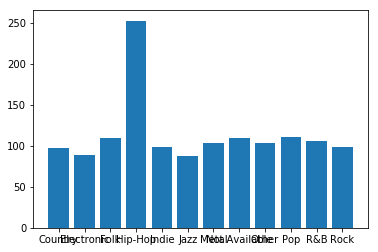

In [21]:
#plt.bar(range(len(D)), list(D.values()), align='center')
#plt.xticks(range(len(D)), list(D.keys()))
plt.bar(range(len(genre_wordcount_mean)),list(genre_wordcount_mean.values()),align = 'center')
plt.xticks(range(len(genre_wordcount_mean)),list(genre_wordcount_mean.keys()))
plt.show() #Small amount of variance with the value for hip-hop being an outlier. 

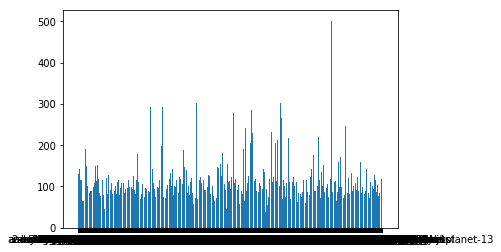

In [22]:
plt.bar(range(len(artist_wordcount_mean)),list(artist_wordcount_mean.values()),align = 'center')
plt.xticks(range(len(artist_wordcount_mean)),list(artist_wordcount_mean.keys()))
plt.show()

#Sufficient amount of variance to suggest that the mean unique word count feature could be a useful one for suggesting songs/artists

In [ ]:
#Measuring the variance in the type token ratio feature


In [23]:
df['genre'].value_counts()

Rock             96456
Pop              32827
Hip-Hop          21927
Metal            19905
Country          13660
Not Available    13397
Jazz              6892
Electronic        5429
R&B               3030
Indie             2389
Folk              1526
Other             1418
Name: genre, dtype: int64

In [24]:
genre_artist_group = df['artist'].groupby(df['genre'])
data = genre_artist_group.describe()

In [25]:
data

,count,unique,top,freq
genre,,,,
Country,13660,200,dolly-parton,741
Electronic,5429,181,bjrthrk,182
Folk,1526,48,celtic-woman,116
Hip-Hop,21927,401,chris-brown,616
Indie,2389,89,devendra-banhart,124
Jazz,6892,133,ella-fitzgerald,571
Metal,19905,566,fall,365
Not Available,13397,481,emma-forman,222
Other,1418,80,cenk-r-lr-etin,107


In [26]:
def word_density(text):
    sentences = text.split(".")
    words = sum(len(sentence.split(" ")) for sentence in sentences)

    return words / len(sentences)



In [27]:
word_density(df.iloc[3]['lyrics'])

6.988505747126437

In [28]:
from textblob import TextBlob
sentiment_polarity = []
df['Sentiment Polarity'] = df['lyrics'].map(lambda x: TextBlob(x).sentiment.polarity)

In [29]:
#Analysing the different genres on basis of sentiment polarity of the lyrics
genre_sentiment_group = df['Sentiment Polarity'].groupby(df['genre'])
gs_data = genre_sentiment_group.describe()

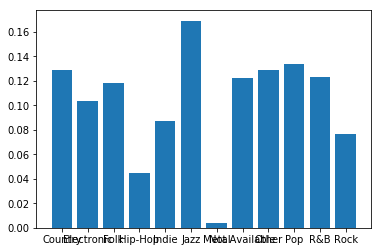

In [30]:
genre_mean_sentiment = {genre:mean_sent for genre,mean_sent in zip(gs_data.index,gs_data['mean'])}
plt.bar(range(len(genre_mean_sentiment)),list(genre_mean_sentiment.values()),align = 'center')
plt.xticks(range(len(genre_mean_sentiment)),list(genre_mean_sentiment.keys()))
plt.show()

In [31]:
word_density_series = df['lyrics'].apply(word_density)
df['Word Density'] = word_density_series

In [32]:
#TODO: Analyse the selected features for information redundancy
df.head()

,song,artist,genre,lyrics,Unique_Word_Count,Type-Token Ratio,Sentiment Polarity,Word Density
0,ego-remix,beyonce-knowles,Pop,"Oh baby, how you doing?. You know I'm gonna cu...",159,0.367206,0.148268,9.640000
1,then-tell-me,beyonce-knowles,Pop,"playin' everything so easy,. it's like you see...",141,0.546512,0.115729,5.849057
2,honesty,beyonce-knowles,Pop,If you search. For tenderness. It isn't hard t...,119,0.700000,0.004720,4.072727
3,you-are-my-rock,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I. [Verse 1:]. If I wrote...",153,0.293103,0.407280,6.988506
4,black-culture,beyonce-knowles,Pop,"Party the people, the people the party it's po...",61,0.195513,-0.170833,10.424242


In [82]:
#TODO: A useful form of clustering of songs is the topics present in a song. As songs can be described along themes of happiness,
#sadness,romance etc, we can use topic modeling to extract more information about our dataset

#Methods to perform topic modeling: LDA, Explicit Semantic Analysis, Non Negative Matrix Factorization


In [174]:
#Using sklearn's LabelBinarizer to get one-hot encoding of the genre attribute
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder
encoder = LabelBinarizer()
one_hot_encoder = OneHotEncoder(sparse = False)

one_hot_encoding = encoder.fit_transform(df['genre'])
#Gives a (261780,12) shaped numpy array

In [178]:
df['Genre_Encoded'] = list(one_hot_encoding)
df['Genre_Encoded'] = df['Genre_Encoded'].map(lambda x: x.astype('float64'))

In [184]:
#Building an SVM Classifier
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df,test_size = 0.25)

In [185]:
df_train_genre = df_train['Genre_Encoded']
df_test_genre = df_test['Genre_Encoded']
df_train_num = df_train.filter(items = ['Unique_Word_Count','Sentiment Polarity'])
df_test_num = df_test.filter(items = ['Unique_Word_Count','Sentiment Polarity'])
#df_train_nolyrics = df_train.copy().drop(columns=['lyrics'])
#df_test_nolyrics = df_test.copy().drop(columns = ['lyrics'])


In [217]:
from sklearn.svm import LinearSVC
svm_classifier = LinearSVC()
svm_classifier.fit(df_train_num,df_train_genre)
#df_train_genre.iloc[0].shape

ValueError: Unknown label type: 'unknown'

In [219]:
df_train_genre.head(5)

157277    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
90109     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
106224    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
221087    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
247082    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: Genre_Encoded, dtype: object

In [57]:
#Do certain word embeddings capture stylistic information such as repetitions, 'rhythm of words' etc ?
from gensim.models import Word2Vec
dylan = df[(df['artist'] == 'bob-dylan')].copy()
beatles = df[(df['artist'] == 'beatles')].copy()


In [60]:
#dylan_corpus = list(dylan['lyrics'])
#dylan_corpus = [x.strip('\n') for x in dylan_corpus ]


In [64]:
dylan_corpus = (list(dylan['lyrics']))
beatles_corpus = (list(beatles['lyrics']))


In [65]:
dylan_vector = Word2Vec(dylan_corpus,size = 100, min_count = 5)

In [67]:
beatles_vector = Word2Vec(beatles_corpus,size = 100, min_count = 5)

In [73]:
def get_song_average(sentence,model):
    word_arrays = []
    for word in sentence:
        try:
            word_vector = model[word]
            #word_vector = word_vector.reshape(1,100)
            word_arrays.append(word_vector)
        except KeyError:
            pass
        res = np.mean(word_arrays,axis=0)
        #res = res.reshape(1,100)
    return res

In [83]:
b1 = get_song_average(beatles.iloc[0]['lyrics'],beatles_vector).reshape(1,-1)
b2 = get_song_average(beatles.iloc[10]['lyrics'],beatles_vector).reshape(1,-1)

C:\Users\Mudit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [84]:
d1 = get_song_average(dylan.iloc[0]['lyrics'],dylan_vector).reshape(1,-1)
d2 = get_song_average(dylan.iloc[10]['lyrics'],dylan_vector).reshape(1,-1)

C:\Users\Mudit\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [76]:
from sklearn.metrics.pairwise import cosine_similarity

In [85]:
cosine_similarity(b1,d1)


array([[0.5542706]], dtype=float32)

In [86]:
cosine_similarity(b1,b2)

array([[0.98612154]], dtype=float32)

In [87]:
cosine_similarity(d1,d2)

array([[0.9841837]], dtype=float32)

In [2]:
#Average similarity measure for the two selected artists:
len(dylan)

NameError: name 'dylan' is not defined

In [33]:
#Writing the dataframe with tehe appended features back into a csv for later analysis:
df.to_csv('lyrics_extended.csv',index = False)

In [ ]:
#Random text here